In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import tf2onnx
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.backend import ctc_decode
import tf2onnx
import onnxruntime as ort

In [2]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        # ← Accept **kwargs so trainable, dtype, etc. get passed through
        super().__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # same as before
        batch_len    = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")

        input_length = input_length * tf.ones((batch_len, 1), dtype="int32")
        label_length = label_length * tf.ones((batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

    def get_config(self):
        # so that save()/load_model() knows how to reconstruct it
        base_config = super().get_config()
        return base_config

In [ ]:
import os
# (Optional) suppress TF’s Metal logs so you just see the essentials
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

# Hide all GPUs (this includes the MPS/Metal device on macOS)
tf.config.set_visible_devices([], 'GPU')

# Now when you load, Keras will fall back to CPU-based LSTMs
training_model = load_model(
    'cnn-lstm-ctc.keras',
    custom_objects={'CTCLayer': CTCLayer}
)

# Re‑create your inference model
image_input    = training_model.inputs[0]
softmax_output = training_model.get_layer('softmax_dense').output
inference_model = Model(inputs=image_input, outputs=softmax_output)

# Convert with standard LSTM ops
spec = (tf.TensorSpec(inference_model.inputs[0].shape, tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(
    inference_model,
    input_signature=spec,
    opset=13,
    output_path="cnn-lstm-ctc (inference only) fp32.onnx"
)
print("✅ Converted to ONNX with CPU LSTMs!")

TF freezing failed. Attempting to fix freezing errors.
Removed Mul functional_1/bidirectional_1_2/backward_lstm_1_1/AssignVariableOp
Removed FloorMod functional_1/bidirectional_1_2/forward_lstm_1_1/AssignVariableOp
Removed FloorMod functional_1/bidirectional_1/backward_lstm_1/AssignVariableOp
Removed FloorMod functional_1/bidirectional_1/forward_lstm_1/AssignVariableOp


✅ Converted to ONNX with CPU LSTMs!


In [6]:
vocab = [' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
char_list = sorted(vocab)

# Step 2: Create forward mapper (no OOV, no mask)
char_to_num = layers.StringLookup(
    vocabulary=char_list,
    num_oov_indices=0,
    mask_token=None
)

# Step 3: Get vocab from char_to_num
vocab = char_to_num.get_vocabulary()  

# Step 4: Create inverse mapper WITHOUT SHIFT
# This skips using `invert=True` (which adds [UNK])
num_to_char = layers.StringLookup(
    vocabulary=vocab,
    mask_token=None,
    num_oov_indices=0,
    invert=True
)

INPUTS : ['input']
OUTPUTS: ['softmax_dense']


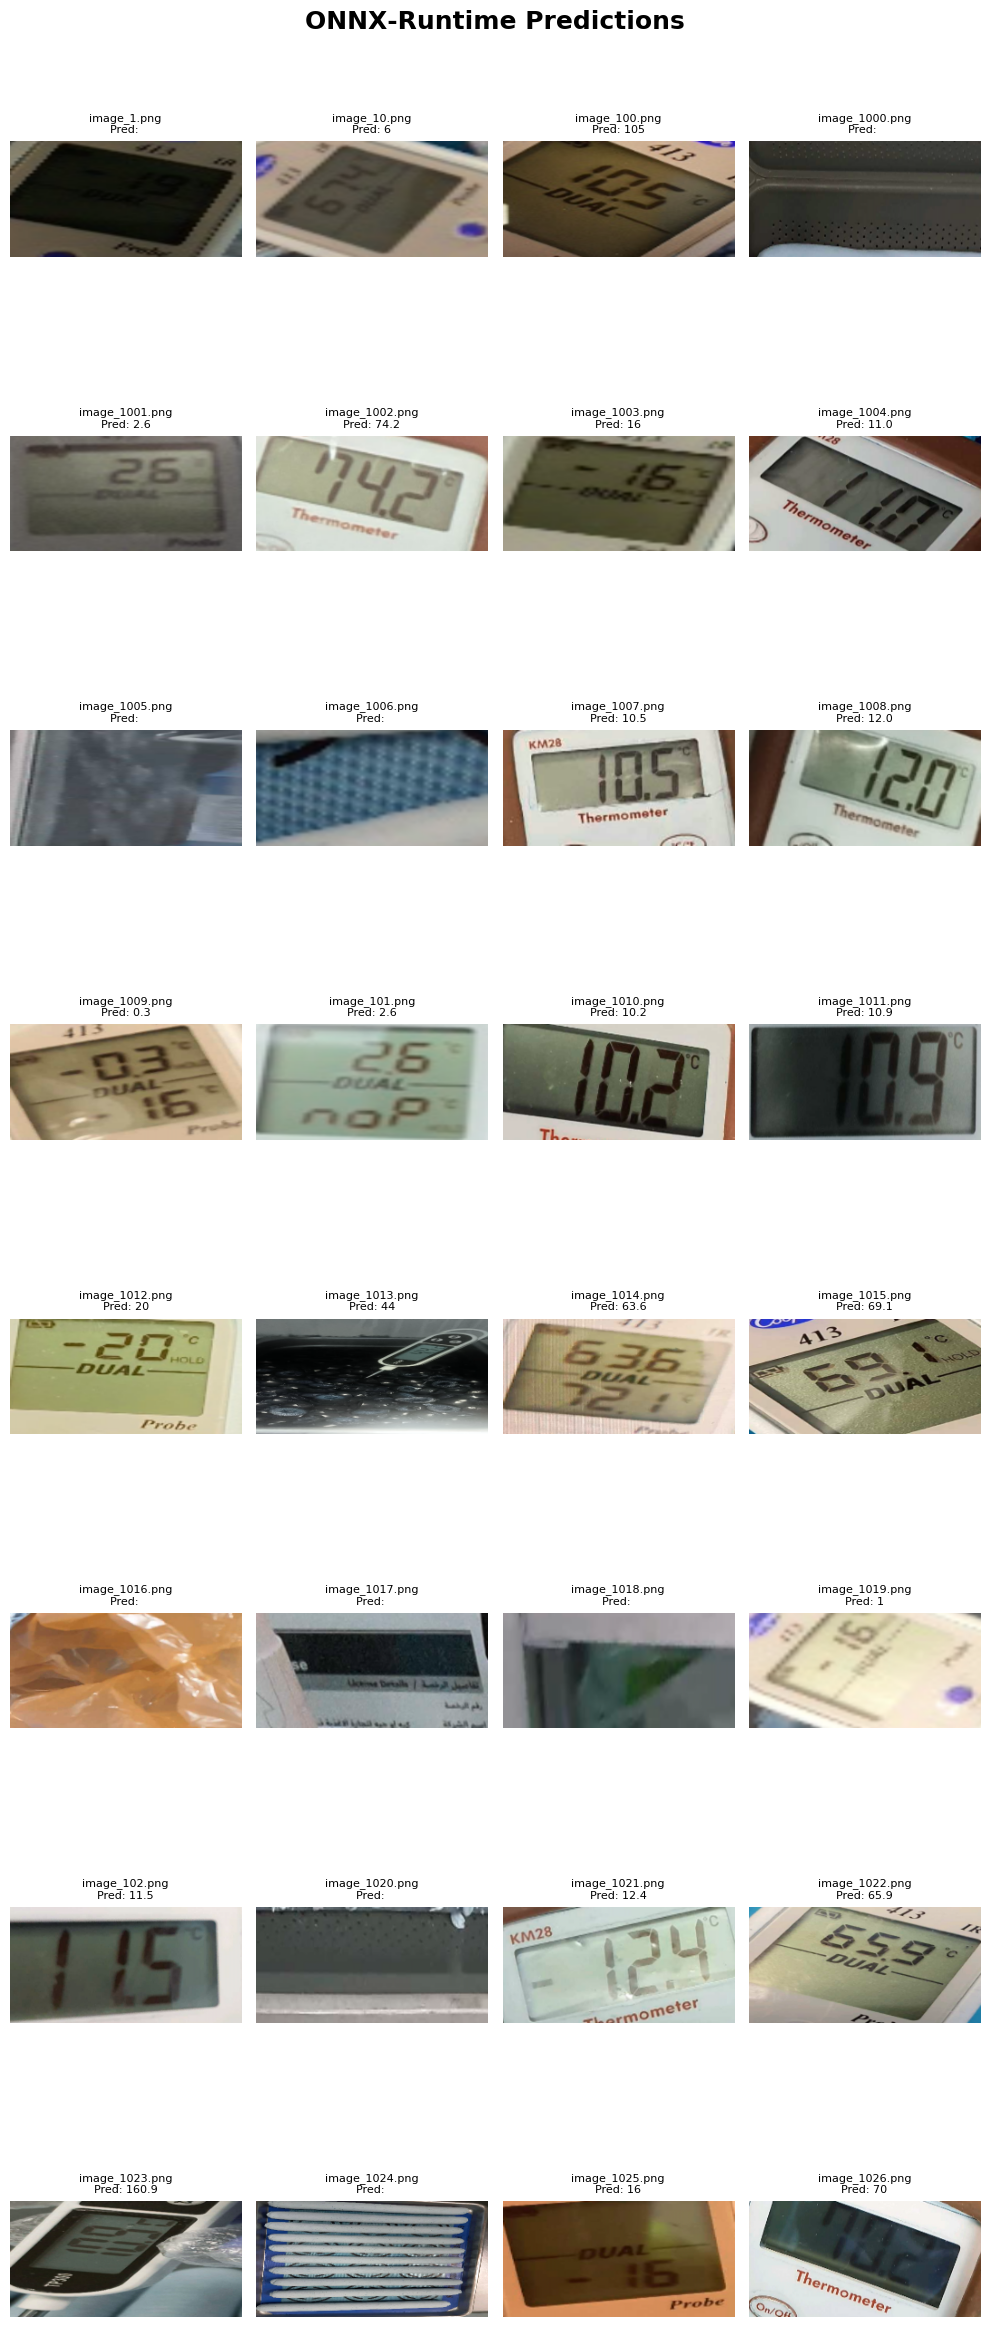

In [9]:
# ── 1) Set up your ONNX session ────────────────────────────────────────────────
ort_session = ort.InferenceSession(
    "cnn-lstm-ctc (inference only) fp32.onnx",
    providers=["CPUExecutionProvider"]       # or ["CUDAExecutionProvider"] if you have GPU support
)

# (Optional) print the input / output names to verify
print("INPUTS :", [i.name for i in ort_session.get_inputs()])
print("OUTPUTS:", [o.name for o in ort_session.get_outputs()])

# ── 2) Define a wrapper that mimics `model.predict()` ─────────────────────────
def onnx_predict(images: np.ndarray) -> np.ndarray:
    """
    images: float32 array of shape [batch, H, W, C], already normalized
    returns: softmax logits of shape [batch, T, num_chars]
    """
    # Name must match the input tensor name in the ONNX graph:
    input_name = ort_session.get_inputs()[0].name
    
    # Ensure dtype=float32
    if images.dtype != np.float32:
        images = images.astype(np.float32)
    
    # Run inference
    outputs = ort_session.run(None, {input_name: images})
    
    # outputs is a list; for a single-output model it's outputs[0]
    return outputs[0]

# ── 3) Your existing CTC‐decode helper (unchanged) ───────────────────────────────
def decode_batch_predictions(pred, max_label_len=32):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # greedy CTC decode
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_label_len]
    output_text = []
    for res in results:
        text = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        text = text.replace('[UNK]', '')
        output_text.append(text)
    return output_text

def load_images_from_folder(folder, num_images=32, target_size=(256,128)):
    """
    Load and preprocess first `num_images` from a given folder.
    Resize to `target_size` and normalize to [0, 1].
    """
    image_list = []
    filenames = []

    for fname in sorted(os.listdir(folder))[:num_images]:
        path = os.path.join(folder, fname)
        img = cv2.imread(path)  # or IMREAD_COLOR based on your model input
        if img is None:
            continue
        img = cv2.resize(img, target_size)
        img = img.astype("float32") / 255.0
        image_list.append(img)
        filenames.append(fname)

    return np.array(image_list), filenames

def visualize_predictions_onnx_from_folder(folder_path, num_images=32):
    """
    Visualize predictions on first `num_images` from folder using ONNX model.
    """
    images, filenames = load_images_from_folder(folder_path, num_images=num_images)

    # Predict using ONNX model
    preds = onnx_predict(images)  # You must define this to use ONNXRuntime inference
    pred_texts = decode_batch_predictions(preds)

    rows, cols = 8, 4
    fig, ax = plt.subplots(rows, cols, figsize=(10, 25))
    fig.suptitle("ONNX‑Runtime Predictions", fontsize=18, fontweight='bold')

    for i in range(min(num_images, len(images))):
        img = (images[i] * 255).astype("uint8").squeeze()
        ax_i = ax[i // cols, i % cols]
        ax_i.imshow(img, cmap="gray")
        ax_i.set_title(f"{filenames[i]}\nPred: {pred_texts[i]}", fontsize=8)
        ax_i.axis("off")

    plt.tight_layout()
    plt.show()

folder_path = 'Images/ocr2-2000'
visualize_predictions_onnx_from_folder(folder_path, num_images=32)